In [2]:
!pip install mne
!pip install h5py

!pip install datalad-installer
!datalad-installer git-annex -m datalad/packages -y
!pip install datalad

Usage: datalad-installer [<options>] git-annex[=VERSION] [<options>]

option -y not recognized


In [2]:
import sys
import numpy as np
import pandas as pd
import mne
import os
import scipy.io
import scipy.signal
from functools import partial
import matplotlib.pyplot as plt
import h5py
import pickle
import time

In [3]:
channelsList = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'CP3', 'CP4', 'CP5', 'CP6', 'FZ', 'CZ', 'PZ']
sampleFrequency = 500

In [4]:
class SignalExtraction():

    @staticmethod
    def fn_signal_extraction_openneuro(raw_signal_obj, channels_subset=None):
        dict_x, dict_y = {}, {}
        for channel in raw_signal_obj.ch_names:
            signal_channel = raw_signal_obj[channel]
            y, x = signal_channel
            y, x = y.flatten(), x.flatten()
            dict_y[channel] = y
            dict_x[channel] = x
        signal_df = pd.DataFrame(dict_x)
        signal_df = signal_df[channels_subset] if channels_subset else signal_df
        signal_np = np.array(signal_df).transpose()
        return signal_np

    @staticmethod
    def fn_signal_extraction_predict_d006(raw_signal_obj, channels_subset=None):
        raw_signal = raw_signal_obj['EEG'][0][0]
        channels = [i[0][0] for i in raw_signal[21].reshape(-1)]
        signals = raw_signal[15]
        control_treatment = raw_signal[0][0]
        label = raw_signal[-2][0]
        # label_binary = 0 if label == 'no' else (1 if label == 'yes' else -1)
        assert signals.shape[0] == len(channels)
        signals = signals.transpose()
        signal_df = pd.DataFrame(signals, columns=channels)
        signal_df = signal_df[channels_subset] if channels_subset else signal_df
        signal_np = np.array(signal_df).transpose()
        return signal_np, control_treatment, label

    @staticmethod
    def read_mat_iterator(path, num: None):
        lst = []
        i = 0
        for root, _, files in os.walk(path):
            for name in files:
                i = i+1
                mat_file = os.path.join(root, name)
                mat = scipy.io.loadmat(mat_file)
                signal_np, control_treatment, label = SignalExtraction.fn_signal_extraction_predict_d006(mat, channelsList)
                lst.append((signal_np, control_treatment, label))
                if num and i == num:
                    return lst
        return lst



    @staticmethod
    def get_participants_data_openneuro(file):
        df_participants = pd.read_csv(file, delimiter="\t")
        return df_participants

    @staticmethod
    def get_electrodes_coordinates(file, channelsList):
        df_coordinates = pd.read_csv(file, delimiter="\t")
        df1 = df_coordinates[df_coordinates.name.map(lambda x: x in channelsList)]
        df2 = df1.set_index('name')
        df3 = df2.reindex(channelsList)
        return df3

    @staticmethod
    def fn_label_extraction_openneuro(subject, df):
        BDI_obj = df[df.participant_id == subject].BDI
        return BDI_obj.values[0]

    @staticmethod
    def read_mne_iterator(path, num: None):
        lst = []
        i = 0
        df = SignalExtraction.get_participants_data_openneuro(path+'participants.tsv')

        def fn_read_EEG(root, run, channelsList):
            set_file = run['set']
            coordiantes_file = run['electrodes']
            name_split = set_file.split('_')
            subject_id = name_split[0]+'_'+name_split[2]
            bdi = SignalExtraction.fn_label_extraction_openneuro(name_split[0], df)
            mne_file = os.path.join(root, set_file)
            mne_obj = mne.io.read_raw_eeglab(mne_file)
            signal_np = SignalExtraction.fn_signal_extraction_openneuro(mne_obj, channelsList)
            coordiantesFile = os.path.join(root, coordiantes_file)
            df_coordinates = SignalExtraction.get_electrodes_coordinates(coordiantesFile, channelsList)
            return subject_id, signal_np, df_coordinates, bdi

        for root, _, files in os.walk(path):
            if root.endswith('eeg'):
                run1, run2 = {}, {}
                for name in files:
                    if '_run-01_' in name:
                        if '_eeg.set' in name:
                            run1['set'] = name
                        if '_electrodes.tsv' in name:
                            run1['electrodes'] = name
                    if '_run-02_' in name:
                        if '_eeg.set' in name:
                            run2['set'] = name
                        if '_electrodes.tsv' in name:
                            run2['electrodes'] = name

                print('<<<<<<<Processing {}>>>>>>>'.format(root))
                for run in [run1, run2]:
                    if run:
                        try:
                            subject_id, signal_np, df_coordinates, bdi = fn_read_EEG(root, run, channelsList)
                            lst.append((subject_id, signal_np, df_coordinates, bdi))
                        except Exception:
                            print('<<<<<<<Error in {}>>>>>>>'.format(run))
                            continue
                i = i+1
                if num and i == num:
                    return lst
        return lst

In [5]:
class SignalProcessing():

    @staticmethod
    def bandpass_filter(edges: list[float], sample_rate: float, poles: int, data: np.ndarray):
        sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
        filtered_data = scipy.signal.sosfiltfilt(sos, data)
        return filtered_data

    @staticmethod
    def notch_filter(frequency_toRemove: float, quality_factor: float, sample_frequency: float, data: np.ndarray):
        b, a = scipy.signal.iirnotch(frequency_toRemove, quality_factor, sample_frequency)
        return b, a

    @staticmethod
    def resample(data: np.ndarray, sample_frequency: float, downsample_frequency: float):
        n = data.shape[1]
        num = (n//sample_frequency)*downsample_frequency
        return scipy.signal.resample(data, num, axis=1)

    @staticmethod
    def data_augmentation(signal, sample_freq: int, window_size: int, stride_size: int):
        N = signal.shape[1]
        f = window_size*sample_freq
        s = stride_size*sample_freq
        n = (N-f+s)//s
        lst = [signal[:, i*s:i*s+f] for i in range(n)]
        tensor = np.stack(lst, axis=0)
        return tensor

    @staticmethod
    def fn_tensor(signal, n_slices):
        signal_slices = np.hsplit(signal, n_slices)
        tensor = np.stack(signal_slices, axis=0)
        return tensor

    @staticmethod
    def tensor_generator(signal, sample_freq, time_slice_size):
        n = signal.shape[1]
        assert n%sample_freq == 0
        t = n//sample_freq
        assert t%time_slice_size == 0
        n_time_slices = t//time_slice_size
        return SignalProcessing.fn_tensor(signal, n_time_slices)

    @staticmethod
    def signal_processing(np_array, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size):

        bandpass_filter = partial(SignalProcessing.bandpass_filter, band_freq_range, sample_freq, 5)
        signal_processed1 = np.apply_along_axis(bandpass_filter, 1, np_array)
        signal_processed2 = SignalProcessing.resample(signal_processed1, sample_freq, downsample_freq)

        window_size = slice_size
        stride_size = window_size//3
        signal_augmented = SignalProcessing.data_augmentation(signal_processed2, downsample_freq, window_size, stride_size)

        signal_tensors = [SignalProcessing.tensor_generator(signal_slice, downsample_freq, sub_slice_size) for signal_slice in signal_augmented]
        tensor = np.stack(signal_tensors, axis=0)

        return tensor

    @staticmethod
    def AdjMatrix(df_electrodes_coordinates):
        np_coordinates = np.array(df_electrodes_coordinates)
        _, b = np_coordinates.shape
        lst = []
        for i in range(b):
            f = np_coordinates[:,i]
            d = f.reshape(-1,1)-f.reshape(1,-1)
            d_square = d**(2)
            lst.append(d_square)
        tensor = np.stack(lst, axis=0)
        tensor_dist_sq = tensor.sum(axis=0)
        tensor_dist = tensor_dist_sq**(1/2)
        max, min = tensor_dist.min(), tensor_dist.max()
        tensor_dist_norm = (tensor_dist-min)/(max-min)
        tensor_dist_norm = tensor_dist_norm if np.linalg.det(tensor_dist_norm) else np.array([])
        return tensor_dist_norm

    @staticmethod
    def to_bdi_label(bdi):
        bdi_label = None
        if bdi < 7:
            bdi_label = 0
        if bdi >=17:
            bdi_label = 1
        if bdi >= 7 and bdi < 17:
            bdi_label = 1/2
        return bdi_label

    @staticmethod
    def to_h5(file_path, subject, signal_array, label, frequency):
        with h5py.File(file_path, "w") as hf:
                hf.create_dataset("subject", data=subject)
                hf.create_dataset("resampled_signal", data=signal_array)
                hf.create_dataset("resample_freq", data=frequency)
                hf.create_dataset("label", data=label)
        return

    @staticmethod
    def signal_processing_iterator(data_lst, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size):
        correct_data_lst = []
        error_data_lst = []
        for subject_id, signal_np, df_coordinates, bdi in data_lst:
            signal_processed = SignalProcessing.signal_processing(signal_np, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size)
            Adj_dist_matrix = SignalProcessing.AdjMatrix(df_coordinates)
            bdi_label = SignalProcessing.to_bdi_label(bdi)
            if bdi_label in [0, 1] and Adj_dist_matrix.size:
                correct_data_lst.append((subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label))
            else:
                error_data_lst.append((subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label))

        return correct_data_lst, error_data_lst

In [6]:
class TrainingData():

    @staticmethod
    def signal_to_trainingData(signal_tuple):
        ls = []
        subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label = signal_tuple
        print(Adj_dist_matrix)
        for signal_slice in signal_processed:
            ls.append((signal_slice, Adj_dist_matrix, bdi_label))
        return ls

    def trainingData_iterator(signal_tuples):
        ls = []
        for signal_tuple in signal_tuples:
            ls = ls+TrainingData.signal_to_trainingData(signal_tuple)
        return ls

In [7]:
root_path = '/content/drive/MyDrive/'
file_path_openneuro = 'EEG (1)/'

file_path = root_path + file_path_openneuro


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
file_path = root_path+file_path_openneuro

start = time.time()
ls = SignalExtraction.read_mne_iterator(file_path, None)
end = time.time()

print(end - start)

<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-001/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-001/eeg/sub-001_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-001/eeg/sub-001_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-007/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-007/eeg/sub-007_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-007/eeg/sub-007_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-010/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-010/eeg/sub-010_task-Rest_run-01_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-115/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-115/eeg/sub-115_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-115/eeg/sub-115_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-060/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-060/eeg/sub-060_task-Rest_run

<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-060/eeg/sub-060_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-066/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-066/eeg/sub-066_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-066/eeg/sub-066_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-111/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-111/eeg/sub-111_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-111/eeg/sub-111_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-011/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-011/eeg/sub-011_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-011/eeg/sub-011_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-088/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-088/eeg/sub-088_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-088/eeg/sub-088_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-016/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-016/eeg/sub-016_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-016/eeg/sub-016_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-020/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-020/eeg/sub-020_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-020/eeg/sub-020_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-092/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-092/eeg/sub-092_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-092/eeg/sub-092_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-099/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-099/eeg/sub-099_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-099/eeg/sub-099_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-100/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-100/eeg/sub-100_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-100/eeg/sub-100_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-108/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-108/eeg/sub-108_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-108/eeg/sub-108_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-117

<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-122/eeg/sub-122_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-065/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-065/eeg/sub-065_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-065/eeg/sub-065_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-080/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-080/eeg/sub-080_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-080/eeg/sub-080_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-084/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-084/eeg/sub-084_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-084/eeg/sub-084_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-098/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-098/eeg/sub-098_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-098/eeg/sub-098_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-102/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-102/eeg/sub-102_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-102/eeg/sub-102_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-113/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-113/eeg/sub-113_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-113/eeg/sub-113_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-118

<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-052/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-052/eeg/sub-052_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-052/eeg/sub-052_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-053/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-053/eeg/sub-053_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-053/eeg/sub-053_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-055/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-055/eeg/sub-055_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-055/eeg/sub-055_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-023/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-023/eeg/sub-023_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-023/eeg/sub-023_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-032/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-032/eeg/sub-032_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-032/eeg/sub-032_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-033/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-033/eeg/sub-033_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-033/eeg/sub-033_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-003/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-003_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-003/eeg/sub-003_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-003_task-Rest_run-02_electrodes.tsv', 'set': 'sub-003_task-Rest_run-02_eeg.set'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-004/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-004/eeg/sub-004_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-004/eeg/sub-004_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-005/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-005/eeg/sub-005_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-005/eeg/sub-005_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-006/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-006/eeg/sub-006_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-006/eeg/sub-006_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-008/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-008/eeg/sub-008_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-008/eeg/sub-008_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-009/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-009/eeg/sub-009_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-009/eeg/sub-009_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-013/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-013/eeg/sub-013_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-013/eeg/sub-013_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-014/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-014/eeg/sub-014_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-014/eeg/sub-014_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-015/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-015/eeg/sub-015_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-015/eeg/sub-015_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-015_task-Rest_run-02_electrodes.tsv', 'set': 'sub-015_task-Rest_run-02_eeg.set'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-012/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-012_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-012/eeg/sub-012_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-012_task-Rest_run-02_electrodes.tsv', 'set': 'sub-012_task-Rest_run-02_eeg.set'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-017/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-017/eeg/sub-017_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)
<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-017/eeg/sub-017_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-018/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-018/eeg/sub-018_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-018/eeg/sub-018_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-019/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-019/eeg/sub-019_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-019/eeg/sub-019_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-021/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-021/eeg/sub-021_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-021/eeg/sub-021_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-022/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-022/eeg/sub-022_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-022/eeg/sub-022_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-101/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-101/eeg/sub-101_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-101/eeg/sub-101_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-101_task-Rest_run-02_electrodes.tsv', 'set': 'sub-101_task-Rest_run-02_eeg.set'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-103/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-103_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-103/eeg/sub-103_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'set': 'sub-103_task-Rest_run-02_eeg.set', 'electrodes': 'sub-103_task-Rest_run-02_electrodes.tsv'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-097/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-097_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-097/eeg/sub-097_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'set': 'sub-097_task-Rest_run-02_eeg.set', 'electrodes': 'sub-097_task-Rest_run-02_electrodes.tsv'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-024/eeg>>>>>>>
Reading /c

<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-024/eeg/sub-024_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-026/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-026/eeg/sub-026_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-026/eeg/sub-026_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-025/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-025/eeg/sub-025_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-025/eeg/sub-025_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-027/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-027/eeg/sub-027_task-Rest_run-01_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Reading /content/drive/MyDrive/EEG (1)/sub-027/eeg/sub-027_task-Rest_run-02_eeg.fdt


<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-086/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-086/eeg/sub-086_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-086/eeg/sub-086_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-081/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-081/eeg/sub-081_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-081/eeg/sub-081_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-085/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-085/eeg/sub-085_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-085/eeg/sub-085_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-058/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-058/eeg/sub-058_task-Rest_run-01_eeg.fdt
Reading /content/drive/MyDrive/EEG (1)/sub-058/eeg/sub-058_task-Rest_run-02_eeg.fdt
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-059

<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-061/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-061_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-061/eeg/sub-061_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-061_task-Rest_run-02_electrodes.tsv', 'set': 'sub-061_task-Rest_run-02_eeg.set'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-063/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-063_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-063/eeg/sub-063_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-063_task-Rest_run-02_electrodes.tsv', 'set': 'sub-063_task-Rest_run-02_eeg.set'}>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG (1)/sub-096/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-096_task-Rest_run-01_electrodes.tsv'}>>>>>>>
Reading /content/drive/MyDrive/EEG (1)/sub-096/eeg/sub-096_task-Rest_run-02_eeg.fdt
<<<<<<<Error in {'electrodes': 'sub-096_task-Rest_run

<ipython-input-4-d681b901eb74>:80: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


In [10]:

sliceSize = 6
bandFreqRange = [0.5, 100]
downsampleFreq = 200
subSliceSize = 2

start = time.time()
training_data, error_data = SignalProcessing.signal_processing_iterator(ls, sampleFrequency, bandFreqRange, downsampleFreq, sliceSize, subSliceSize)
end = time.time()

print(end - start)

len(training_data)

60.812931060791016


107

In [11]:
X = TrainingData.trainingData_iterator(training_data)

[[ 1.          0.69222989  0.68006384  0.47389196  0.3656436   0.20536524
   0.13553197  0.03975436  0.04853925 -0.          0.69082757  0.41414814
   0.23728597  0.10748157  0.27143607  0.10154848  0.57895032  0.27562275
   0.07372896]
 [ 0.69222989  1.          0.47361009  0.68018759  0.20539181  0.36561032
   0.03977494  0.13538332 -0.          0.04853925  0.4138147   0.69122534
   0.10748157  0.23728597  0.10154848  0.27143607  0.57895032  0.27562275
   0.07372896]
 [ 0.68006384  0.47361009  1.          0.43263348  0.63576756  0.25495979
   0.32215194  0.11590596  0.13553197  0.03977494  0.69337624  0.25758736
   0.46946995  0.17671919  0.45759422  0.10329728  0.69301541  0.48416574
   0.23895702]
 [ 0.47389196  0.68018759  0.43263348  1.          0.25521416  0.63553368
   0.11590596  0.32179859  0.03975436  0.13538332  0.25761978  0.69324935
   0.1768895   0.46926929  0.10347372  0.45730089  0.69339718  0.48430465
   0.23894483]
 [ 0.3656436   0.20539181  0.63576756  0.25521416  1

In [12]:
# Distribution of categorical Variable

bdi = []
adj = []

for i in X:
    signal_slice, Adj_dist_matrix, bdi_label = i
    bdi.append(bdi_label)
    adj.append(Adj_dist_matrix)



In [13]:
np.array(adj).shape

(18358, 19, 19)

# DATA VISUALISATION

In [1]:
# bdi = np.array(bdi)

# # Count the occurrences of each category in bdi
# unique, counts = np.unique(bdi, return_counts=True)

# # Calculate the proportions
# proportions = counts / len(bdi)

# # Print the counts and proportions
# for label, count, proportion in zip(unique, counts, proportions):
#     print(f"Label: {label}, Count: {count}, Proportion: {proportion:.2f}")

# # Plot the distribution
# plt.figure(figsize=(8, 6))
# plt.bar(unique, counts, tick_label=unique)
# plt.xlabel('BDI Labels')
# plt.ylabel('Count')
# plt.title('Distribution of BDI Labels')
# plt.show()

In [83]:
# path = file_path+'TrainingData_Pickle/'+'training_data.p'
# pickle.dump(X, open( path, "wb" ))

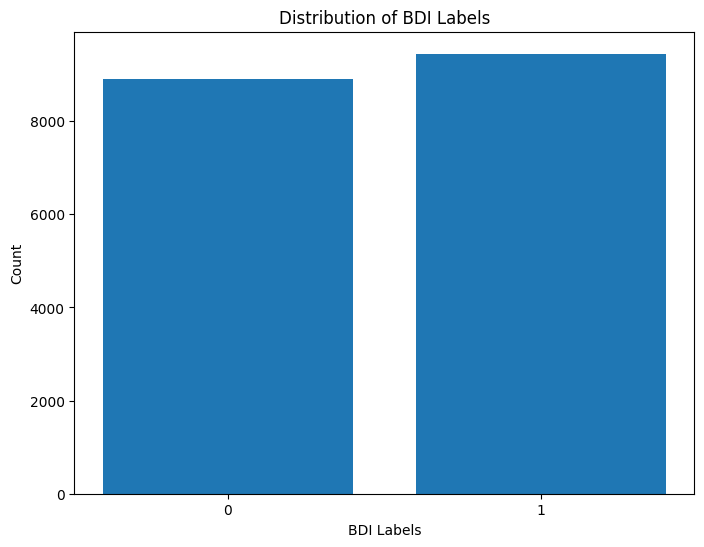

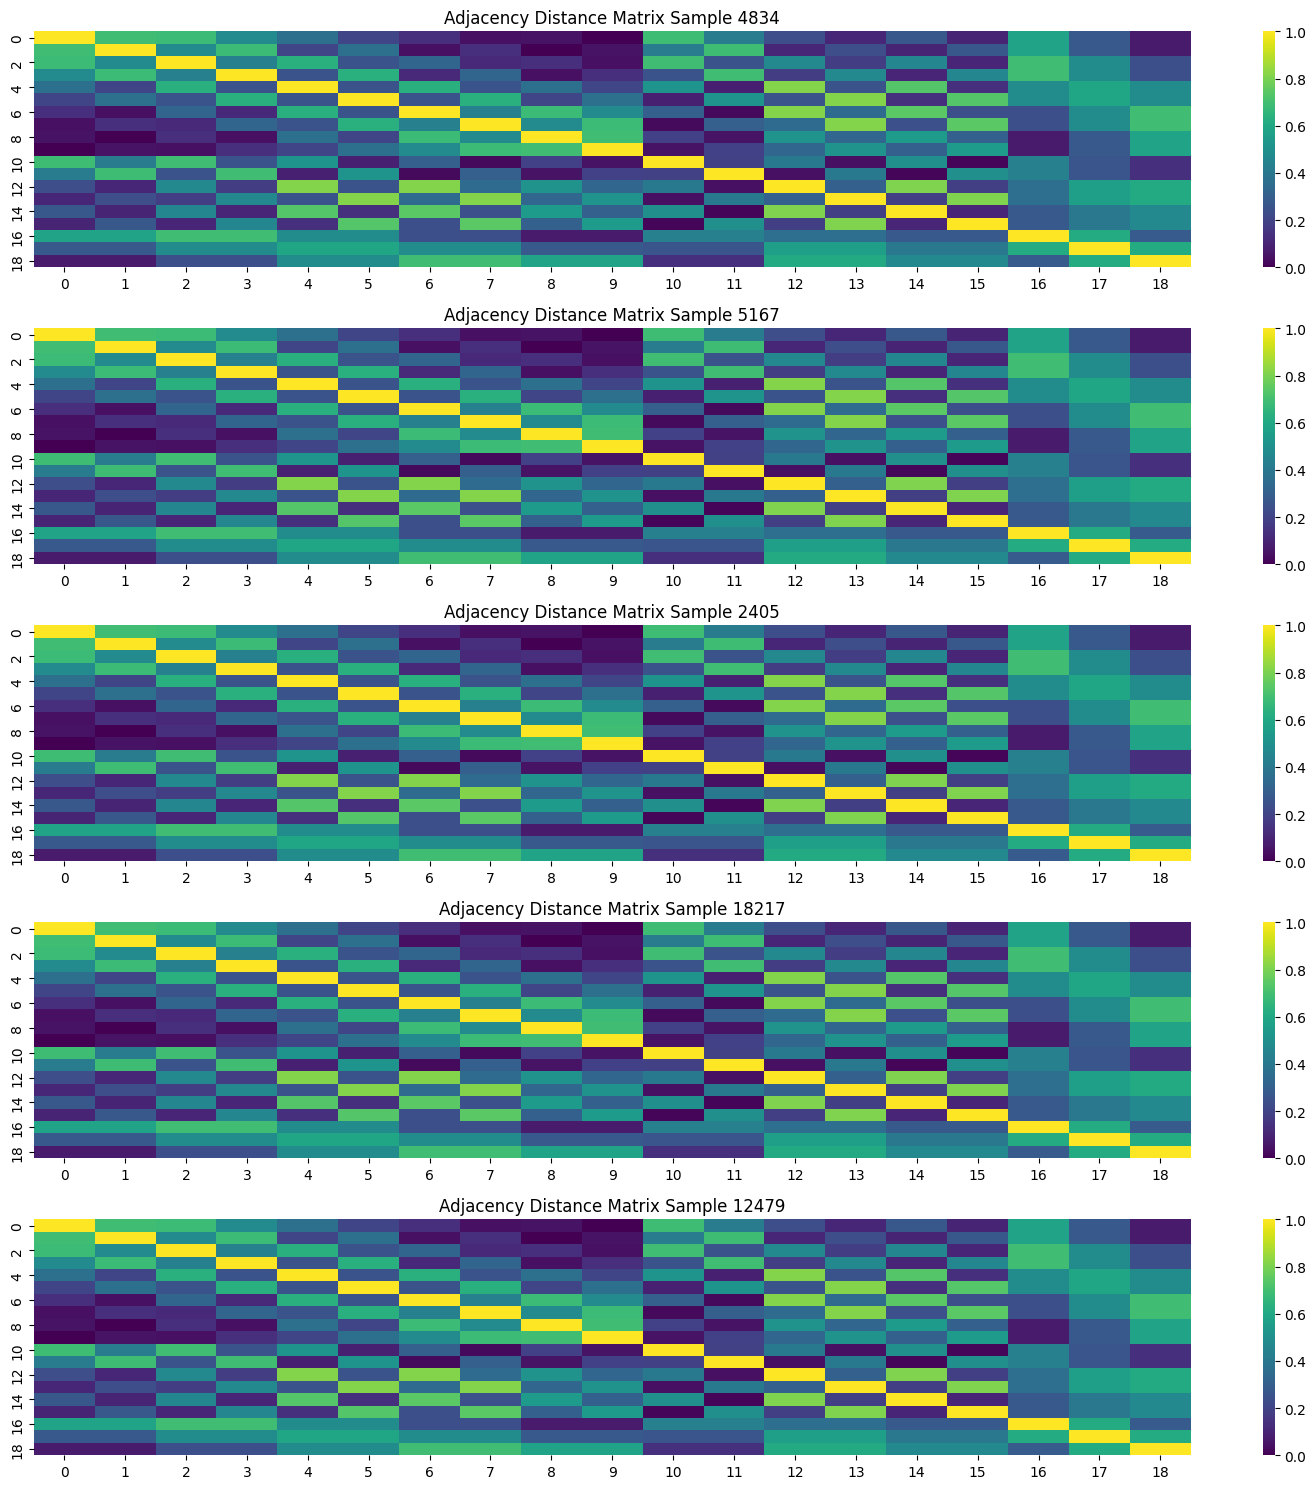

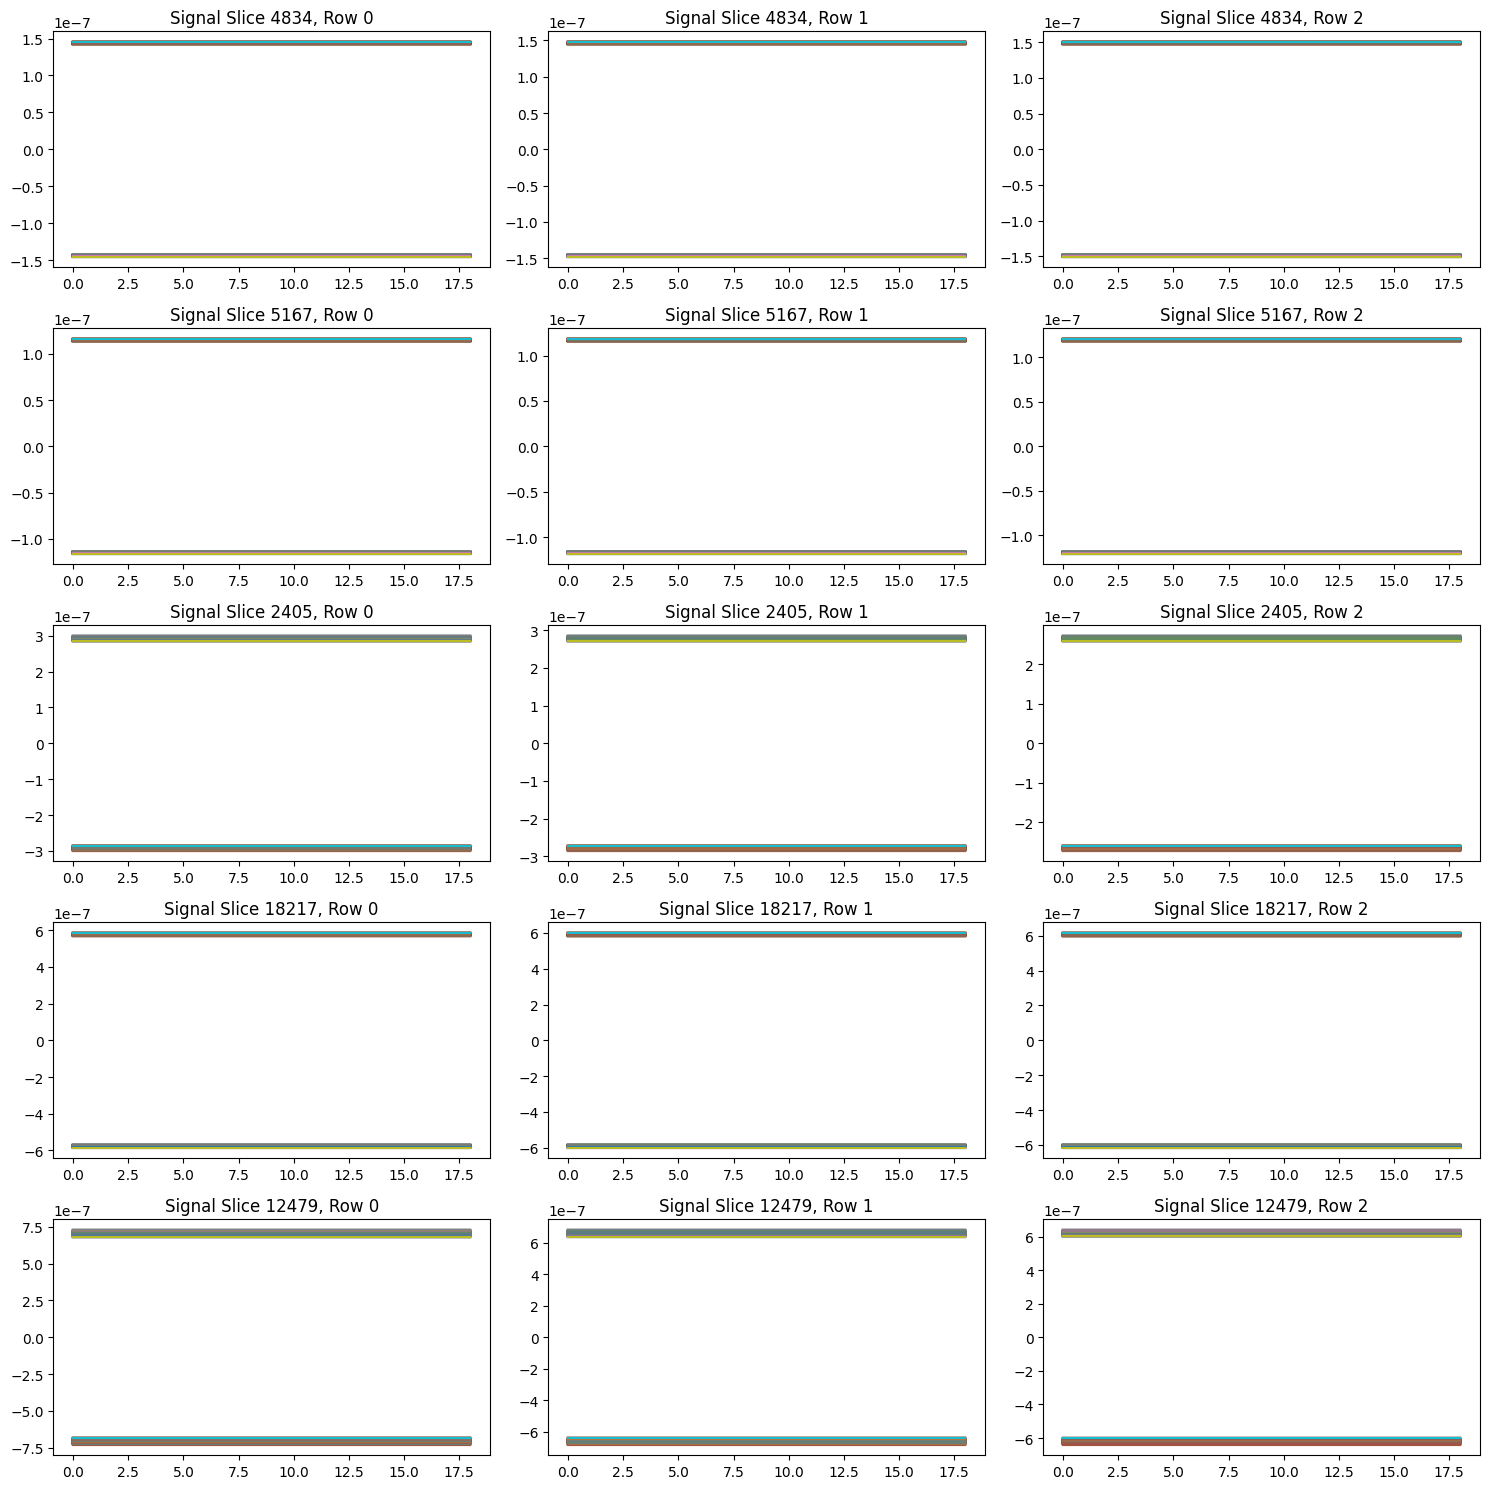

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X is your dataset
# X = [...]

bdi = []
adj = []
signals = []

for i in X:
    signal_slice, Adj_dist_matrix, bdi_label = i
    signals.append(signal_slice)
    adj.append(Adj_dist_matrix)
    bdi.append(bdi_label)

# Convert to numpy arrays for easier manipulation
bdi = np.array(bdi)
adj = np.array(adj)
signals = np.array(signals)

# Distribution of BDI labels
unique, counts = np.unique(bdi, return_counts=True)
proportions = counts / len(bdi)

# Plot distribution of BDI labels
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, tick_label=unique)
plt.xlabel('BDI Labels')
plt.ylabel('Count')
plt.title('Distribution of BDI Labels')
plt.show()

# Plot a few sample adjacency distance matrices as heatmaps
num_samples = 5
sample_indices = np.random.choice(len(adj), num_samples, replace=False)

plt.figure(figsize=(15, 3 * num_samples))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i + 1)
    sns.heatmap(adj[idx], annot=False, cmap='viridis')
    plt.title(f'Adjacency Distance Matrix Sample {idx}')

plt.tight_layout()
plt.show()

# Plot a few sample signal slices
plt.figure(figsize=(15, 3 * num_samples))
for i, idx in enumerate(sample_indices):
    for j in range(signals.shape[1]):
        plt.subplot(num_samples, signals.shape[1], i * signals.shape[1] + j + 1)
        plt.plot(signals[idx][j])
        plt.title(f'Signal Slice {idx}, Row {j}')
        plt.tight_layout()

plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

CACHE

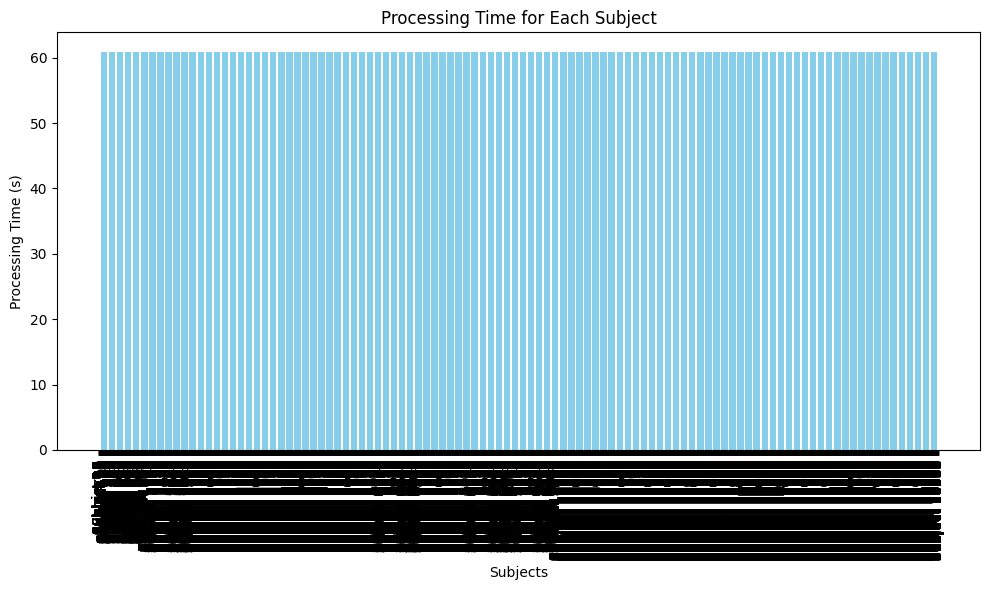

In [27]:
import matplotlib.pyplot as plt
import time

# Simulate data for processing times (in seconds)
subjects = [f'Subject {i}' for i in range(1, len(ls) + 1)]
processing_times = [end - start]  # Replace with actual processing times if available

plt.figure(figsize=(10, 6))
plt.bar(subjects, processing_times, color='skyblue')
plt.xlabel('Subjects')
plt.ylabel('Processing Time (s)')
plt.title('Processing Time for Each Subject')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt
import numpy as np

class DataVisualization:

    @staticmethod
    def plot_raw_signal(signal, title, channel_names=None):
        """
        Plots the raw signal with optional channel names.
        """
        n_channels = signal.shape[0]
        fig, axs = plt.subplots(n_channels, 1, figsize=(10, 6*n_channels), sharex=True)
        fig.suptitle(title, fontsize=16)

        if n_channels == 1:
            axs.plot(signal[0])
            if channel_names:
                axs.set_title(channel_names[0])
        else:
            for i, ax in enumerate(axs):
                ax.plot(signal[i])
                if channel_names:
                    ax.set_title(channel_names[i])

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_filtered_signal(signal_filtered, title, channel_names=None):
        """
        Plots the filtered signal with optional channel names.
        """
        n_channels = signal_filtered.shape[0]
        fig, axs = plt.subplots(n_channels, 1, figsize=(10, 6*n_channels), sharex=True)
        fig.suptitle(title, fontsize=16)

        if n_channels == 1:
            axs.plot(signal_filtered[0])
            if channel_names:
                axs.set_title(channel_names[0])
        else:
            for i, ax in enumerate(axs):
                ax.plot(signal_filtered[i])
                if channel_names:
                    ax.set_title(channel_names[i])

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_adjacency_matrix(adj_matrix, title):
        """
        Plots the adjacency matrix.
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        fig.suptitle(title, fontsize=16)
        im = ax.imshow(adj_matrix, cmap='viridis')
        ax.set_xticks(np.arange(adj_matrix.shape[1]))
        ax.set_yticks(np.arange(adj_matrix.shape[0]))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.colorbar(im, ax=ax)
        plt.show()

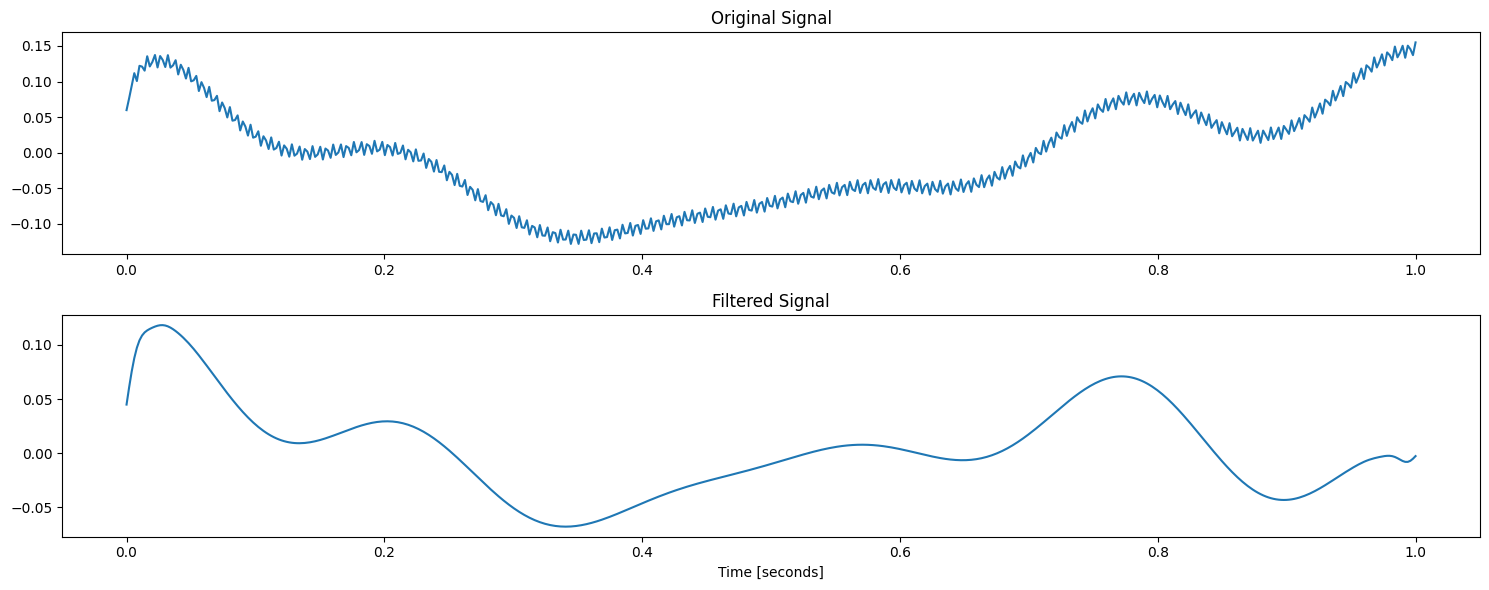

In [38]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt


fs = 500  # Sample rate, Hz
t = np.linspace(0, 1.0, fs)
a = 0.02
f0 = 5.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))  # the signal
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)

# Bandpass filter
edges = [1, 50]
poles = 4
sos = scipy.signal.butter(poles, edges, 'bandpass', fs=fs, output='sos')
filtered_data = scipy.signal.sosfiltfilt(sos, x)

# Plot the original and filtered signal
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(t, filtered_data)
plt.title('Filtered Signal')
plt.xlabel('Time [seconds]')
plt.tight_layout()
plt.show()


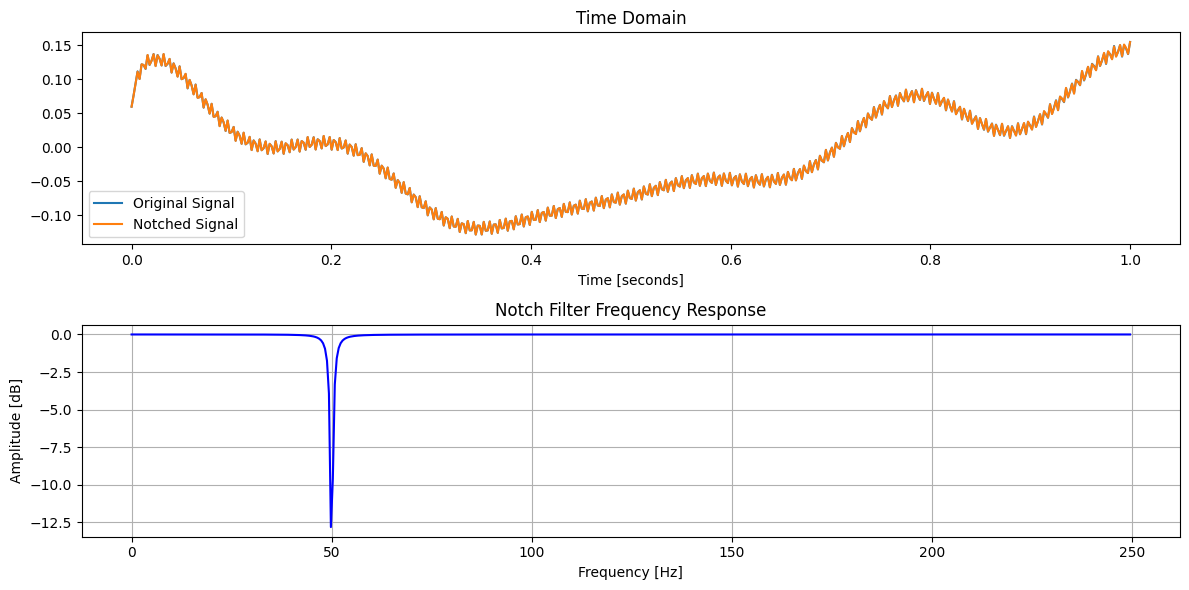

In [39]:
# Notch filter
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
b, a = scipy.signal.iirnotch(f0, Q, fs)
notched_data = scipy.signal.filtfilt(b, a, x)

# Frequency response
freq, h = scipy.signal.freqz(b, a, fs=fs)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x, label='Original Signal')
plt.plot(t, notched_data, label='Notched Signal')
plt.title('Time Domain')
plt.xlabel('Time [seconds]')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freq, 20 * np.log10(abs(h)), 'b')
plt.title('Notch Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid()
plt.tight_layout()
plt.show()


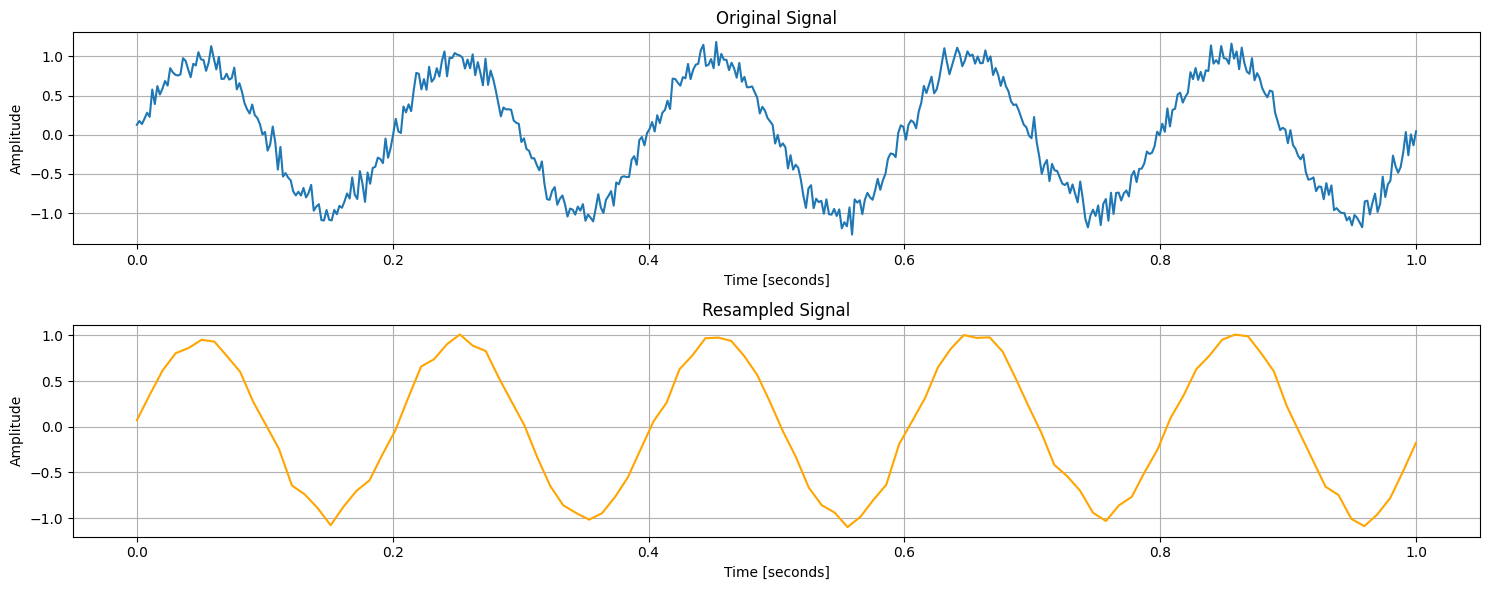

In [40]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt


fs = 500  # Original sample rate, Hz
t = np.linspace(0, 1.0, fs)
x = np.sin(2 * np.pi * 5 * t) + np.random.normal(0, 0.1, t.shape)

# Resample to a lower rate
downsample_fs = 100
num_samples = int(len(x) * downsample_fs / fs)
resampled_data = scipy.signal.resample(x, num_samples)
t_resampled = np.linspace(0, 1.0, num_samples)

# Plot the original and resampled signal
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(t, x, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_resampled, resampled_data, label='Resampled Signal', color='orange')
plt.title('Resampled Signal')
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()


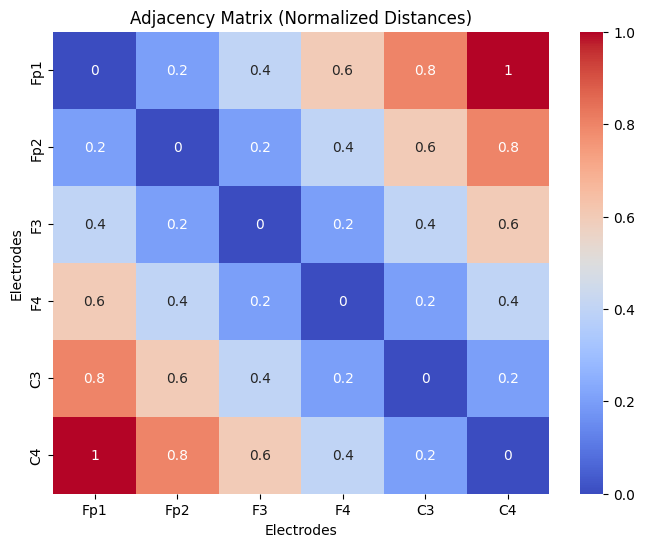

In [72]:
import pandas as pd
import seaborn as sns


coordinates = {
    'name': ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4'],
    'x': [1, 2, 3, 4, 5, 6],
    'y': [1, 2, 3, 4, 5, 6],
    'z': [1, 2, 3, 4, 5, 6]
}
df_coordinates = pd.DataFrame(coordinates).set_index('name')

# Adjacency matrix calculation
np_coordinates = np.array(df_coordinates)
dist_sq = np.sum((np_coordinates[:, np.newaxis, :] - np_coordinates[np.newaxis, :, :]) ** 2, axis=-1)
dist = np.sqrt(dist_sq)
dist_norm = (dist - dist.min()) / (dist.max() - dist.min())

# Plot the adjacency matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dist_norm, annot=True, cmap='coolwarm', xticklabels=df_coordinates.index, yticklabels=df_coordinates.index)
plt.title('Adjacency Matrix (Normalized Distances)')
plt.xlabel('Electrodes')
plt.ylabel('Electrodes')
plt.show()
